# Data Loading and Preperation

Hard coded directory pathways, search and replace: /content/drive/My Drive/Colab Notebooks/258_project_personal/

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

### Read the data labels and convert it into one hot labels

In [0]:
# Read Data Labels
hand_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/train.csv', header = 0)

In [0]:
train_label = hand_train['label']

In [0]:
train_label_oh = pd.get_dummies(hand_train['label'])

In [0]:
train_label_oh_np = np.asarray(train_label_oh)

### Define a function that reads an image and saves it as an array

In [0]:
# Most models expect 224x224 image but can accept 192 which is an even upsample from 64x64
#TARGET_SIZE = 192
#TARGET_SIZE = 64
TARGET_SIZE = 224

In [0]:
def read_image(image_file):
  image_matrix = Image.open(image_file)
  width,height = image_matrix.size
  normalized_image = np.asarray(image_matrix) / 255
  return normalized_image.reshape(width,height,1)

In [0]:
def reshape_input_image(image_file):
  image_matrix = Image.open(image_file)
  image_matrix= image_matrix.resize([TARGET_SIZE,TARGET_SIZE])
  normalized_image = np.asarray(image_matrix) / 255
  # Repeat the b/w values on all 3 channels
  out_image = np.array((normalized_image,normalized_image,normalized_image))
  # Channel last for easy visualization
  return np.moveaxis(out_image,0,-1)

### Load the images into an array

In [9]:
train_data = np.empty((hand_train.shape[0],TARGET_SIZE,TARGET_SIZE,3))
for i in range(len(hand_train)):
  train_data[i]= reshape_input_image("/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/train/{}.jpg".format(i+1))
  print('\r', 'Loading Data', i+1, '/', len(hand_train), end='')

 Loading Data 1500 / 1500

Image Label: 9
Onehot Representation of label: [0 0 0 0 0 0 0 0 0 1]


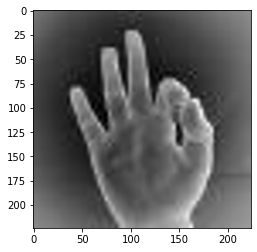

In [10]:
plt.imshow(train_data[258])
print('Image Label:',train_label[258])
print('Onehot Representation of label:',train_label_oh_np[258])

In [0]:
# Input the image with limited reshaping
train_data_d = np.empty((hand_train.shape[0],64,64,1))
for i in range(len(hand_train)):
  train_data_d[i]= read_image("/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/train/{}.jpg".format(i+1))
  print('\r', 'Loading Data', i+1, '/', len(hand_train), end='')

 Loading Data 1500 / 1500

In [0]:
plt.imshow(np.squeeze(train_data_d[258]),cmap='gray')
print('Image Label:',train_label[258])
print('Onehot Representation of label:',train_label_oh_np[258])

### Prepare the Test Data

In [0]:
# Read Data Labels
hand_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/test.csv', header = 0)

Test set doesnt have labels, must be manually checked for performance

In [13]:
test_data = np.empty((hand_train.shape[0],TARGET_SIZE,TARGET_SIZE,3))
for i in range(len(hand_test)):
  test_data[i]= reshape_input_image("/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/test/{}.jpg".format(i+1))
  print('\r', 'Loading Data', i+1, '/', len(hand_test), end='')

 Loading Data 562 / 562

In [0]:
test_data_d = np.empty((hand_train.shape[0],64,64,1))
for i in range(len(hand_test)):
  test_data_d[i]= read_image("/content/drive/My Drive/Colab Notebooks/258_project_personal/sign_language/test/{}.jpg".format(i+1))
  print('\r', 'Loading Data', i+1, '/', len(hand_test), end='')

 Loading Data 562 / 562

## Perform Train Validation Split

In [0]:
data_train, data_val, label_train, label_val = train_test_split(train_data, train_label_oh_np, test_size = 0.2, random_state = 258, stratify = train_label_oh)

In [0]:
data_train_d, data_val_d, label_train_d, label_val_d = train_test_split(train_data_d, train_label_oh_np, test_size = 0.2, random_state = 258, stratify = train_label_oh)

In [18]:
print('Train data shape:', data_train.shape)
print('Train label shape:', label_train.shape)
print('Val data shape:', data_val.shape)
print('Val data shape:', label_val.shape)

Train data shape: (1200, 224, 224, 3)
Train label shape: (1200, 10)
Val data shape: (300, 224, 224, 3)
Val data shape: (300, 10)


# Define the Data Generators and Models

In [0]:
import keras
from keras import Sequential, applications, layers, losses, callbacks
from keras.preprocessing.image import ImageDataGenerator
import h5py

In [0]:
# Model Generation Parameters
DROPOUT_RATE = 0.6
RAND_SEED = 258

## Mobilenet V2

##### Default Setup for Mobilenet Transfer Learning with Dropout Layer

In [0]:
# Utilize Sequential for predict_classes function
mobilenet_v2 = Sequential()
mobilenet_v2.add(layers.UpSampling3D(size=(3,3,3), input_shape = (64,64,1)))
mobilenet_v2.add(applications.MobileNetV2(input_shape = (TARGET_SIZE,TARGET_SIZE,3), alpha=0.35,\
                                          weights = 'imagenet', include_top = False))
mobilenet_v2.add(layers.GlobalAveragePooling2D())
mobilenet_v2.add(layers.Dropout(rate = DROPOUT_RATE, seed = RAND_SEED))
mobilenet_v2.add(layers.Dense(10, activation='softmax'))

2023424/2019640 [==============================] - 0s 0us/step


In [0]:
mobilenet_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_1 (UpSampling3 (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_0.35_192 (Model) (None, 6, 6, 1280)        410208    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 423,018
Trainable params: 408,938
Non-trainable params: 14,080
_________________________________________________________________


##### 3 Channel Input

In [0]:
# Utilize Sequential for predict_classes function
mobilenet_v2_3ch = Sequential()
mobilenet_v2_3ch.add(applications.MobileNetV2(input_shape = (64,64,3), alpha=0.35,\
                                          weights = 'imagenet', include_top = False))
mobilenet_v2_3ch.add(layers.GlobalAveragePooling2D())
mobilenet_v2_3ch.add(layers.Dropout(rate = DROPOUT_RATE, seed = RAND_SEED))
mobilenet_v2_3ch.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
# Utilize Sequential for predict_classes function
mobilenet_v2_3ch_spatial = Sequential()
mobilenet_v2_3ch_spatial.add(applications.MobileNetV2(input_shape = (64,64,3), alpha=0.35,\
                                          weights = 'imagenet', include_top = False))
mobilenet_v2_3ch_spatial.add(layers.SpatialDropout2D(rate = DROPOUT_RATE))
mobilenet_v2_3ch_spatial.add(layers.GlobalAveragePooling2D())
mobilenet_v2_3ch_spatial.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


##### 224 x 3 Net

In [0]:
# Utilize Sequential for predict_classes function
mobilenet_v2 = Sequential()
mobilenet_v2.add(applications.MobileNetV2(input_shape = (224,224,3), alpha=0.35,\
                                              include_top = False))
mobilenet_v2.add(layers.GlobalAveragePooling2D())
mobilenet_v2.add(layers.Dropout(rate = DROPOUT_RATE, seed = RAND_SEED))
mobilenet_v2.add(layers.Dense(10, activation='softmax'))

2023424/2019640 [==============================] - 0s 0us/step


##### Default Setup for Mobilenet Transfer Learning with Spatial Dropout Layer

In [0]:
# Utilize Sequential for predict_classes function
mobilenet_v2_spatial = Sequential()
mobilenet_v2_spatial.add(layers.UpSampling3D(size=(3,3,3), input_shape = (64,64,1)))
mobilenet_v2_spatial.add(applications.MobileNetV2(input_shape = (TARGET_SIZE,TARGET_SIZE,3), alpha=0.35,\
                                          weights = 'imagenet', include_top = False))
mobilenet_v2_spatial.add(layers.SpatialDropout2D(rate = DROPOUT_RATE))
mobilenet_v2_spatial.add(layers.GlobalAveragePooling2D())
mobilenet_v2_spatial.add(layers.Dense(10, activation='softmax'))

In [0]:
mobilenet_v2_spatial.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_2 (UpSampling3 (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_0.35_192 (Model) (None, 6, 6, 1280)        410208    
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 6, 6, 1280)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 423,018
Trainable params: 408,938
Non-trainable params: 14,080
_________________________________________________________________


## NASNetMobile

NASNet requires images to be 224x224 meaning different preprocessing/sampling layer required

##### Default NASNet

In [19]:
nasnet_mobile = Sequential()
nasnet_mobile.add(applications.nasnet.NASNetMobile(input_shape = (TARGET_SIZE,TARGET_SIZE,3),\
                                                   weights = 'imagenet', include_top = False))
nasnet_mobile.add(layers.GlobalAveragePooling2D())
nasnet_mobile.add(layers.Dropout(rate = DROPOUT_RATE, seed = RAND_SEED))
nasnet_mobile.add(layers.Dense(10, activation='softmax'))

19996672/19993432 [==============================] - 1s 0us/step


In [20]:
nasnet_mobile.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1056)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10570     
Total params: 4,280,286
Trainable params: 4,243,548
Non-trainable params: 36,738
_________________________________________________________________


##### NASNet with Spatial Dropout

In [0]:
nasnet_mobile_spatial = Sequential()
nasnet_mobile_spatial.add(applications.nasnet.NASNetMobile(input_shape = (TARGET_SIZE,TARGET_SIZE,3),\
                                                   weights = 'imagenet', include_top = False))
nasnet_mobile_spatial.add(layers.SpatialDropout2D(rate = DROPOUT_RATE))
nasnet_mobile_spatial.add(layers.GlobalAveragePooling2D())
nasnet_mobile_spatial.add(layers.Dense(10, activation='softmax'))

In [0]:
nasnet_mobile_spatial.summary()

## Train the Models

In [0]:
tune_optimizer = 'adam'
tune_loss = losses.CategoricalCrossentropy()
tune_metrics=['categorical_accuracy']
tune_epochs = 75

### Mobilenet V2 Performance

##### 3 Channel

In [0]:
mobilenet_3ch_checkpointer = callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet_3ch_weights.{epoch:02d}.hdf5",\
                                                      verbose=0, save_best_only=True,)
mobilenet_v2_3ch.compile(optimizer = tune_optimizer, loss = tune_loss, metrics = tune_metrics)

In [0]:
mobilenet_3ch_history = mobilenet_v2_3ch.fit(data_train,label_train, batch_size=32,\
                                     validation_data=(data_val,label_val),\
                                     epochs = tune_epochs, callbacks = [mobilenet_3ch_checkpointer])

Train on 1200 samples, validate on 300 samples
Epoch 1/75
1200/1200 [==============================] - 23s 19ms/step - loss: 2.4550 - categorical_accuracy: 0.3642 - val_loss: 7.1375 - val_categorical_accuracy: 0.2267
Epoch 2/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.9761 - categorical_accuracy: 0.6758 - val_loss: 9.0539 - val_categorical_accuracy: 0.2567
Epoch 3/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.5711 - categorical_accuracy: 0.8025 - val_loss: 12.0809 - val_categorical_accuracy: 0.2567
Epoch 4/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.4085 - categorical_accuracy: 0.8717 - val_loss: 9.7392 - val_categorical_accuracy: 0.2767
Epoch 5/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.2476 - categorical_accuracy: 0.9150 - val_loss: 8.0113 - val_categorical_accuracy: 0.3033
Epoch 6/75
1200/1200 [==============================] - 12s 10ms/step - loss: 0.2233 - categorical_accurac

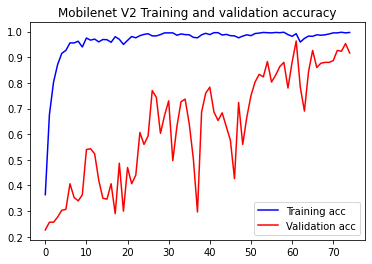

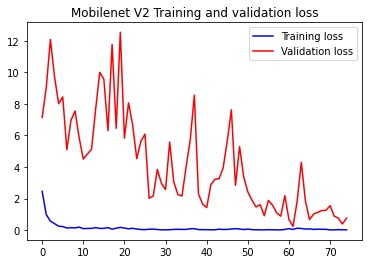

In [0]:
accuracy = mobilenet_3ch_history.history['categorical_accuracy']
val_accuracy = mobilenet_3ch_history.history['val_categorical_accuracy']
loss = mobilenet_3ch_history.history['loss']
val_loss = mobilenet_3ch_history.history['val_loss']

epochs_x = range(len(accuracy))

plt.plot(epochs_x, accuracy, 'b', label='Training acc')
plt.plot(epochs_x, val_accuracy, 'r', label='Validation acc')
plt.title('Mobilenet V2 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'b', label='Training loss')
plt.plot(epochs_x, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet V2 Training and validation loss')
plt.legend()

plt.show()

In [0]:
mobilenet_3ch_spatial_checkpointer = callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet_3ch_spatial_weights.{epoch:02d}.hdf5",\
                                                      verbose=0, save_best_only=True,)
mobilenet_v2_3ch_spatial.compile(optimizer = tune_optimizer, loss = tune_loss, metrics = tune_metrics)

In [0]:
mobilenet_3ch_spatial_history = mobilenet_v2_3ch_spatial.fit(data_train,label_train, batch_size=32,\
                                     validation_data=(data_val,label_val),\
                                     epochs = tune_epochs, callbacks = [mobilenet_3ch_spatial_checkpointer])

Train on 1200 samples, validate on 300 samples
Epoch 1/75
1200/1200 [==============================] - 21s 18ms/step - loss: 2.3425 - categorical_accuracy: 0.3700 - val_loss: 6.1914 - val_categorical_accuracy: 0.1933
Epoch 2/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.8529 - categorical_accuracy: 0.7433 - val_loss: 7.5692 - val_categorical_accuracy: 0.2000
Epoch 3/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.4165 - categorical_accuracy: 0.8692 - val_loss: 6.7768 - val_categorical_accuracy: 0.2633
Epoch 4/75
1200/1200 [==============================] - 11s 9ms/step - loss: 0.3434 - categorical_accuracy: 0.8908 - val_loss: 8.1431 - val_categorical_accuracy: 0.2867
Epoch 5/75
1200/1200 [==============================] - 10s 9ms/step - loss: 0.2570 - categorical_accuracy: 0.9192 - val_loss: 14.3077 - val_categorical_accuracy: 0.2233
Epoch 6/75
1200/1200 [==============================] - 10s 9ms/step - loss: 0.2049 - categorical_accuracy

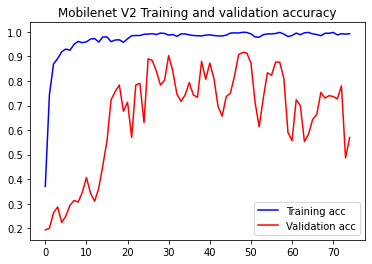

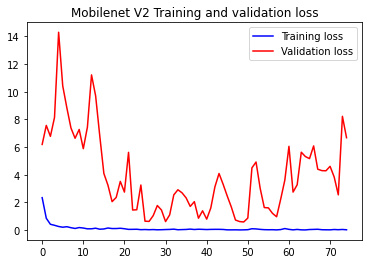

In [0]:
accuracy = mobilenet_3ch_spatial_history.history['categorical_accuracy']
val_accuracy = mobilenet_3ch_spatial_history.history['val_categorical_accuracy']
loss = mobilenet_3ch_spatial_history.history['loss']
val_loss = mobilenet_3ch_spatial_history.history['val_loss']

epochs_x = range(len(accuracy))

plt.plot(epochs_x, accuracy, 'b', label='Training acc')
plt.plot(epochs_x, val_accuracy, 'r', label='Validation acc')
plt.title('Mobilenet V2 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'b', label='Training loss')
plt.plot(epochs_x, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet V2 Training and validation loss')
plt.legend()

plt.show()

##### Transfer Learning using imagenet weights

In [0]:
mobilenet_v2_checkpointer = callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet_weights_224_{epoch:02d}.hdf5",\
                                                      verbose=0, save_best_only=True,)
mobilenet_v2.compile(optimizer = tune_optimizer, loss = tune_loss, metrics = tune_metrics)

In [0]:
mobilenet_history = mobilenet_v2.fit(data_train,label_train, batch_size=32,\
                                     validation_data=(data_val,label_val),\
                                     epochs = tune_epochs, callbacks = [mobilenet_v2_checkpointer])

Train on 1200 samples, validate on 300 samples
Epoch 1/75
1200/1200 [==============================] - 123s 102ms/step - loss: 0.2699 - categorical_accuracy: 0.9075 - val_loss: 2.2110 - val_categorical_accuracy: 0.5533
Epoch 2/75
1200/1200 [==============================] - 110s 91ms/step - loss: 0.0859 - categorical_accuracy: 0.9683 - val_loss: 2.6347 - val_categorical_accuracy: 0.5133
Epoch 3/75
1200/1200 [==============================] - 110s 91ms/step - loss: 0.0229 - categorical_accuracy: 0.9933 - val_loss: 3.0472 - val_categorical_accuracy: 0.4767
Epoch 4/75
1200/1200 [==============================] - 110s 92ms/step - loss: 0.0418 - categorical_accuracy: 0.9875 - val_loss: 3.5985 - val_categorical_accuracy: 0.4067
Epoch 5/75
1200/1200 [==============================] - 112s 93ms/step - loss: 0.0345 - categorical_accuracy: 0.9900 - val_loss: 2.2393 - val_categorical_accuracy: 0.6800
Epoch 6/75
1200/1200 [==============================] - 111s 92ms/step - loss: 0.0138 - categoric

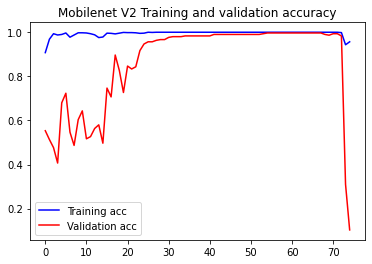

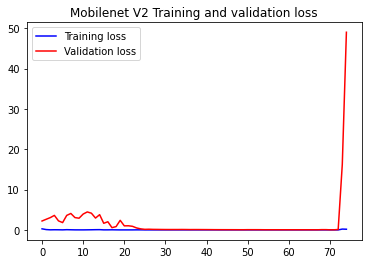

In [0]:
accuracy = mobilenet_history.history['categorical_accuracy']
val_accuracy = mobilenet_history.history['val_categorical_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs_x = range(len(accuracy))

plt.plot(epochs_x, accuracy, 'b', label='Training acc')
plt.plot(epochs_x, val_accuracy, 'r', label='Validation acc')
plt.title('Mobilenet V2 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'b', label='Training loss')
plt.plot(epochs_x, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet V2 Training and validation loss')
plt.legend()

plt.show()

##### Transfer Learning, Spatial Dropout Layer

In [0]:
mobilenet_spatial_checkpointer = callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet_spatial_weights.{epoch:02d}.hdf5",\
                                                      verbose=0, save_best_only=True,)
mobilenet_v2_spatial.compile(optimizer = tune_optimizer, loss = tune_loss, metrics = tune_metrics)

In [0]:
mobilenet_spatial_history = mobilenet_v2_spatial.fit(data_train_d,label_train_d, batch_size=32, validation_data=(data_val_d,label_val_d),\
                                                     epochs = tune_epochs, callbacks = [mobilenet_spatial_checkpointer])

1200/1200 [==============================] - 95s 79ms/step - loss: 1.1520 - categorical_accuracy: 0.6042 - val_loss: 1.1370 - val_categorical_accuracy: 0.6600
Epoch 2/25
1200/1200 [==============================] - 79s 66ms/step - loss: 0.1483 - categorical_accuracy: 0.9492 - val_loss: 1.1231 - val_categorical_accuracy: 0.6433
Epoch 3/25
1200/1200 [==============================] - 79s 66ms/step - loss: 0.0719 - categorical_accuracy: 0.9775 - val_loss: 0.9745 - val_categorical_accuracy: 0.6433
Epoch 4/25
1200/1200 [==============================] - 79s 66ms/step - loss: 0.0358 - categorical_accuracy: 0.9883 - val_loss: 1.2706 - val_categorical_accuracy: 0.6433
Epoch 5/25
1200/1200 [==============================] - 80s 66ms/step - loss: 0.0326 - categorical_accuracy: 0.9900 - val_loss: 0.9834 - val_categorical_accuracy: 0.7633
Epoch 6/25
1200/1200 [==============================] - 81s 67ms/step - loss: 0.0323 - categorical_accuracy: 0.9933 - val_loss: 1.5975 - val_categorical_accuracy

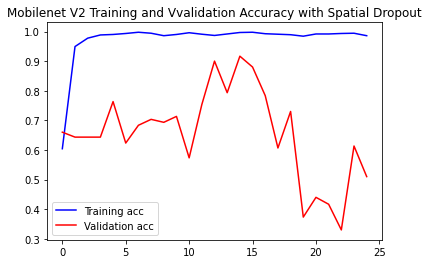

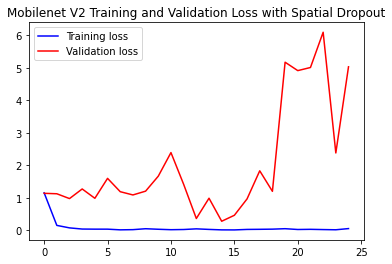

In [0]:
accuracy = mobilenet_spatial_history.history['categorical_accuracy']
val_accuracy = mobilenet_spatial_history.history['val_categorical_accuracy']
loss = mobilenet_spatial_history.history['loss']
val_loss = mobilenet_spatial_history.history['val_loss']

epochs_x = range(len(accuracy))

plt.plot(epochs_x, accuracy, 'b', label='Training acc')
plt.plot(epochs_x, val_accuracy, 'r', label='Validation acc')
plt.title('Mobilenet V2 Training and Vvalidation Accuracy with Spatial Dropout')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'b', label='Training loss')
plt.plot(epochs_x, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet V2 Training and Validation Loss with Spatial Dropout')
plt.legend()

plt.show()

### NASNET Performance

In [0]:
nasnet_checkpointer = callbacks.ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/nasnet_weights.{epoch:02d}.hdf5",\
                                                      verbose=0, save_best_only=True,)
nasnet_mobile.compile(optimizer = tune_optimizer, loss = tune_loss, metrics = tune_metrics)

In [0]:
nasnet_mobile_history = nasnet_mobile.fit(data_train,label_train, batch_size=32, validation_data=(data_val,label_val),\
                                                     epochs = 10, callbacks = [nasnet_checkpointer])

In [0]:
accuracy = nasnet_mobile_history.history['categorical_accuracy']
val_accuracy = nasnet_mobile_history.history['val_categorical_accuracy']
loss = nasnet_mobile_history.history['loss']
val_loss = nasnet_mobile_history.history['val_loss']

epochs_x = range(len(accuracy))

plt.plot(epochs_x, accuracy, 'b', label='Training acc')
plt.plot(epochs_x, val_accuracy, 'r', label='Validation acc')
plt.title('NASNET Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'b', label='Training loss')
plt.plot(epochs_x, val_loss, 'r', label='Validation loss')
plt.title('NASNET Training and Validation Loss')
plt.legend()

plt.show()

# TFLite conversion

In [0]:
import tensorflow as tf
from tensorflow import lite

In [0]:
# Load the model
mobilenet_keras = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet_weights.14.hdf5")

In [0]:
# Predict on test data
loaded_model_prediction = mobilenet_keras.predict_classes(test_data_d)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Predicted class of test image 258: 4


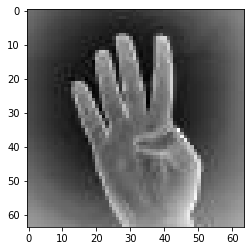

In [0]:
plt.imshow(np.squeeze(test_data_d[258]),cmap='gray')
print('Predicted class of test image 258:', loaded_model_prediction[258])

In [0]:
mobile_to_lite_converter = lite.TFLiteConverter.from_keras_model(mobilenet_keras)
mobile_to_lite_converter.optimizations = [lite.Optimize.DEFAULT]
mobilenet_tflite = mobile_to_lite_converter.convert()
open("/content/drive/My Drive/Colab Notebooks/258_project_personal/saved_models/mobilenet.tflite", "wb").write(mobilenet_tflite)

483424